In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing


from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score,accuracy_score,log_loss
from xgboost import XGBRegressor
import lightgbm as lgb


In [2]:
train_df= pd.read_csv('train.csv',index_col='row_id')
test_df = pd.read_csv('test.csv',index_col ='row_id')

In [3]:
train_df.head()

,date,country,store,product,num_sold
row_id,,,,,
0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


EDA

In [4]:
train_df['date'] = pd.to_datetime(train_df.date, format = "%Y-%m-%d")
test_df['date'] = pd.to_datetime(test_df.date, format = "%Y-%m-%d")

In [5]:
#GDA data

Sweden_ec = {2015:[51545,-.1412],2016:[51965,.0081],2017:[53792,.0351],2018:[54589,.0148],2019:[51687,-.0532]}

Finland_ec = {2015:[42802,-.1495],2016:[43814,.0236],2017:[46412,.0593],2018:[50038,.0781],2019:[48712,-.0265]}

Norway_ec = {2015:[74356,-.2336],2016:[70461,-.0524],2017:[75497,0.0715],2018:[82268,.0897],2019:[75826,-.0783]}


In [6]:
train_df['GDPperCapita'] = [Sweden_ec[a.year][0] if b =='Sweden' else(Finland_ec[a.year][0] if b =='Finland' else Norway_ec[a.year][0]) for a,b in zip(train_df.date,train_df.country)]
train_df['GrowthRate']  = [Sweden_ec[a.year][1] if b =='Sweden' else(Finland_ec[a.year][1] if b =='Finland' else Norway_ec[a.year][1]) for a,b in zip(train_df.date,train_df.country)]

In [7]:
test_df['GDPperCapita'] = [Sweden_ec[a.year][0] if b =='Sweden' else(Finland_ec[a.year][0] if b =='Finland' else Norway_ec[a.year][0]) for a,b in zip(test_df.date,test_df.country)]
test_df['GrowthRate']  = [Sweden_ec[a.year][1] if b =='Sweden' else(Finland_ec[a.year][1] if b =='Finland' else Norway_ec[a.year][1]) for a,b in zip(test_df.date,test_df.country)]

In [8]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

train_df[['GDPperCapita','GrowthRate']] = scaler.fit_transform(train_df[['GDPperCapita','GrowthRate']])
test_df[['GDPperCapita','GrowthRate']] = scaler.transform(test_df[['GDPperCapita','GrowthRate']])

In [9]:
dayOfWeek={'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}
train_df['day_of_week'] = train_df['date'].dt.day_name().map(dayOfWeek)
test_df['day_of_week'] = test_df['date'].dt.day_name().map(dayOfWeek)

In [10]:
train_df['weekend'] = [1 if a in [5,6] else 0 for a in train_df['day_of_week']]
test_df['weekend'] = [1 if a in [5,6] else 0 for a in test_df['day_of_week']]


In [11]:
train_df.head(19)

,date,country,store,product,num_sold,GDPperCapita,GrowthRate,day_of_week,weekend
row_id,,,,,,,,,
0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329,-1.171121,-1.324930,3,0
1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520,-1.171121,-1.324930,3,0
2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146,-1.171121,-1.324930,3,0
3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572,-1.171121,-1.324930,3,0
4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911,-1.171121,-1.324930,3,0
5,2015-01-01,Finland,KaggleRama,Kaggle Sticker,283,-1.171121,-1.324930,3,0
6,2015-01-01,Norway,KaggleMart,Kaggle Mug,526,1.240299,-2.161896,3,0
7,2015-01-01,Norway,KaggleMart,Kaggle Hat,906,1.240299,-2.161896,3,0
8,2015-01-01,Norway,KaggleMart,Kaggle Sticker,250,1.240299,-2.161896,3,0


In [12]:
daily_average_sale = train_df.groupby(by='date').num_sold.mean()

In [13]:
daily_average_sale.values

array([ 598.22222222,  555.44444444,  615.27777778, ..., 1181.16666667,
       1170.88888889,  816.77777778])

In [14]:
daily_average_sale.index

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', name='date', length=1461, freq=None)

Text(0, 0.5, 'Number of Sales')

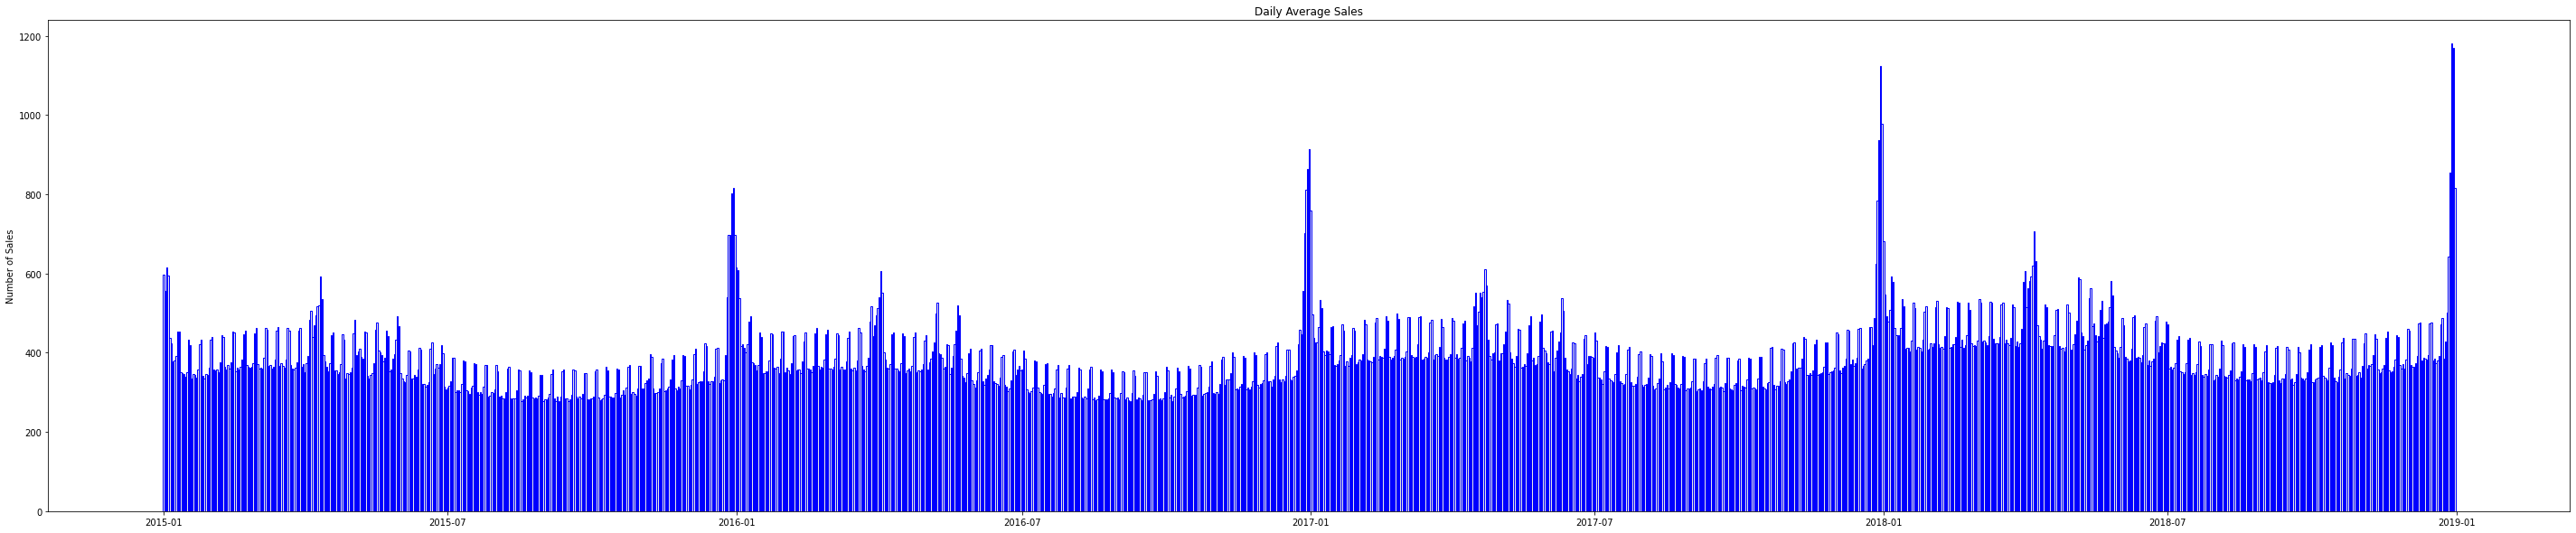

In [15]:
fig = plt.figure(figsize=(50,10))
plt.bar(daily_average_sale.index,daily_average_sale.values,color=(0.1,0.1,0.1,0.1),edgecolor='blue')


plt.title('Daily Average Sales')
plt.ylabel('Number of Sales')

In [16]:
objects =['country','store','product']

for i in objects:
     print(train_df[i].unique())
print('\n')
for i in objects:
    print(test_df[i].unique())


['Finland' 'Norway' 'Sweden']
['KaggleMart' 'KaggleRama']
['Kaggle Mug' 'Kaggle Hat' 'Kaggle Sticker']


['Finland' 'Norway' 'Sweden']
['KaggleMart' 'KaggleRama']
['Kaggle Mug' 'Kaggle Hat' 'Kaggle Sticker']


In [17]:
Finland_KaggleMart = train_df[(train_df.country=='Finland') & (train_df.store =='KaggleMart')]

In [18]:
Finland_KaggleMart

,date,country,store,product,num_sold,GDPperCapita,GrowthRate,day_of_week,weekend
row_id,,,,,,,,,
0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329,-1.171121,-1.324930,3,0
1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520,-1.171121,-1.324930,3,0
2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146,-1.171121,-1.324930,3,0
18,2015-01-02,Finland,KaggleMart,Kaggle Mug,318,-1.171121,-1.324930,4,0
19,2015-01-02,Finland,KaggleMart,Kaggle Hat,493,-1.171121,-1.324930,4,0
...,...,...,...,...,...,...,...,...,...
26263,2018-12-30,Finland,KaggleMart,Kaggle Hat,1113,-0.618131,0.940154,6,1
26264,2018-12-30,Finland,KaggleMart,Kaggle Sticker,326,-0.618131,0.940154,6,1
26280,2018-12-31,Finland,KaggleMart,Kaggle Mug,469,-0.618131,0.940154,0,0


In [19]:
def make_sales_graphs(country,store,product):
    df1 = train_df[(train_df.country== country) & (train_df.store == store)]
    
    df2 = df1[df1['product'] == product]   
    fig = plt.figure(figsize=(50,10))
    plt.bar(df2.date,df2.num_sold)
    fig.suptitle( product + ' Sales - ' + country +' ' + store + ' (2015-2018)',fontsize=20) 
    plt.show()
    
    

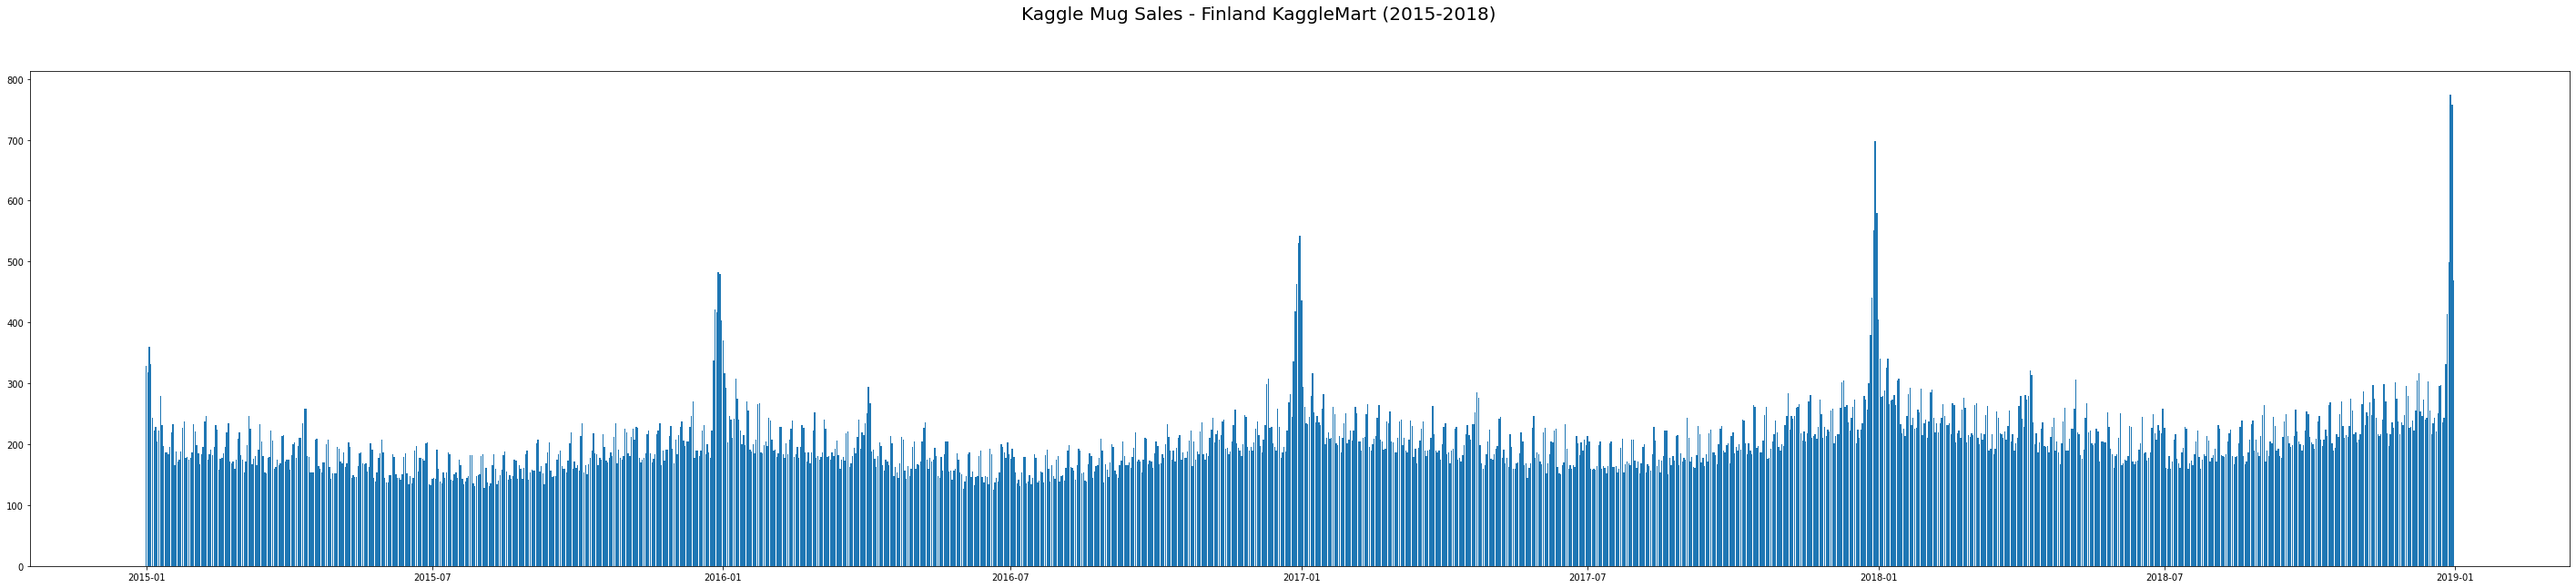

In [20]:
make_sales_graphs('Finland','KaggleMart','Kaggle Mug')

In [21]:
countries = ['Finland', 'Norway', 'Sweden']
stores = ['KaggleMart', 'KaggleRama']
products = ['Kaggle Mug' ,'Kaggle Hat', 'Kaggle Sticker']

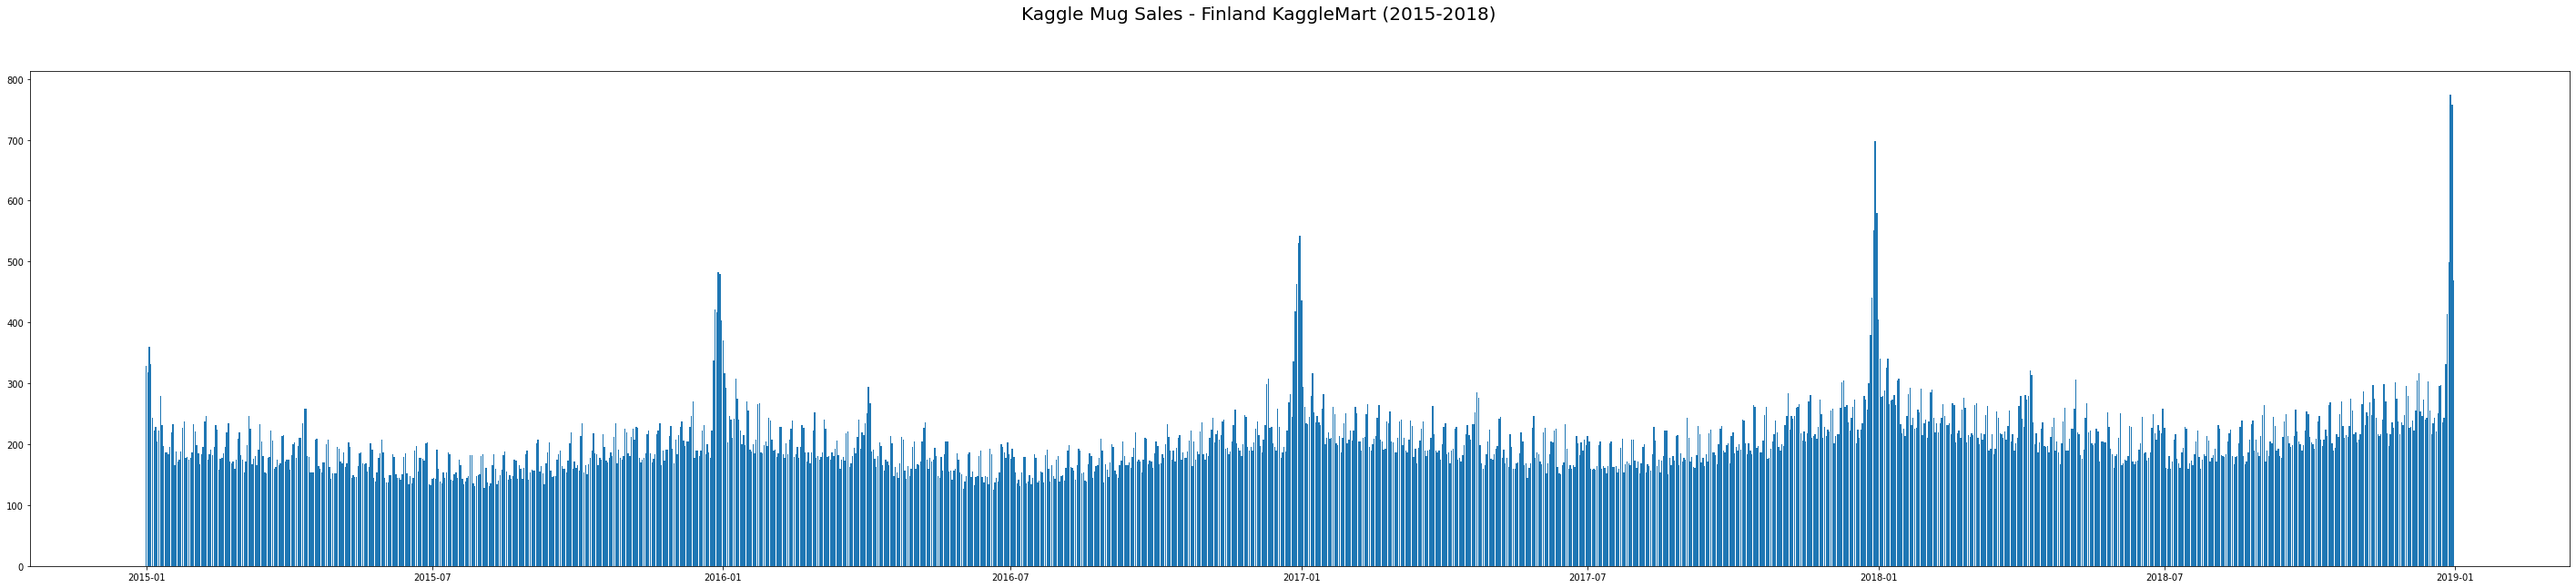

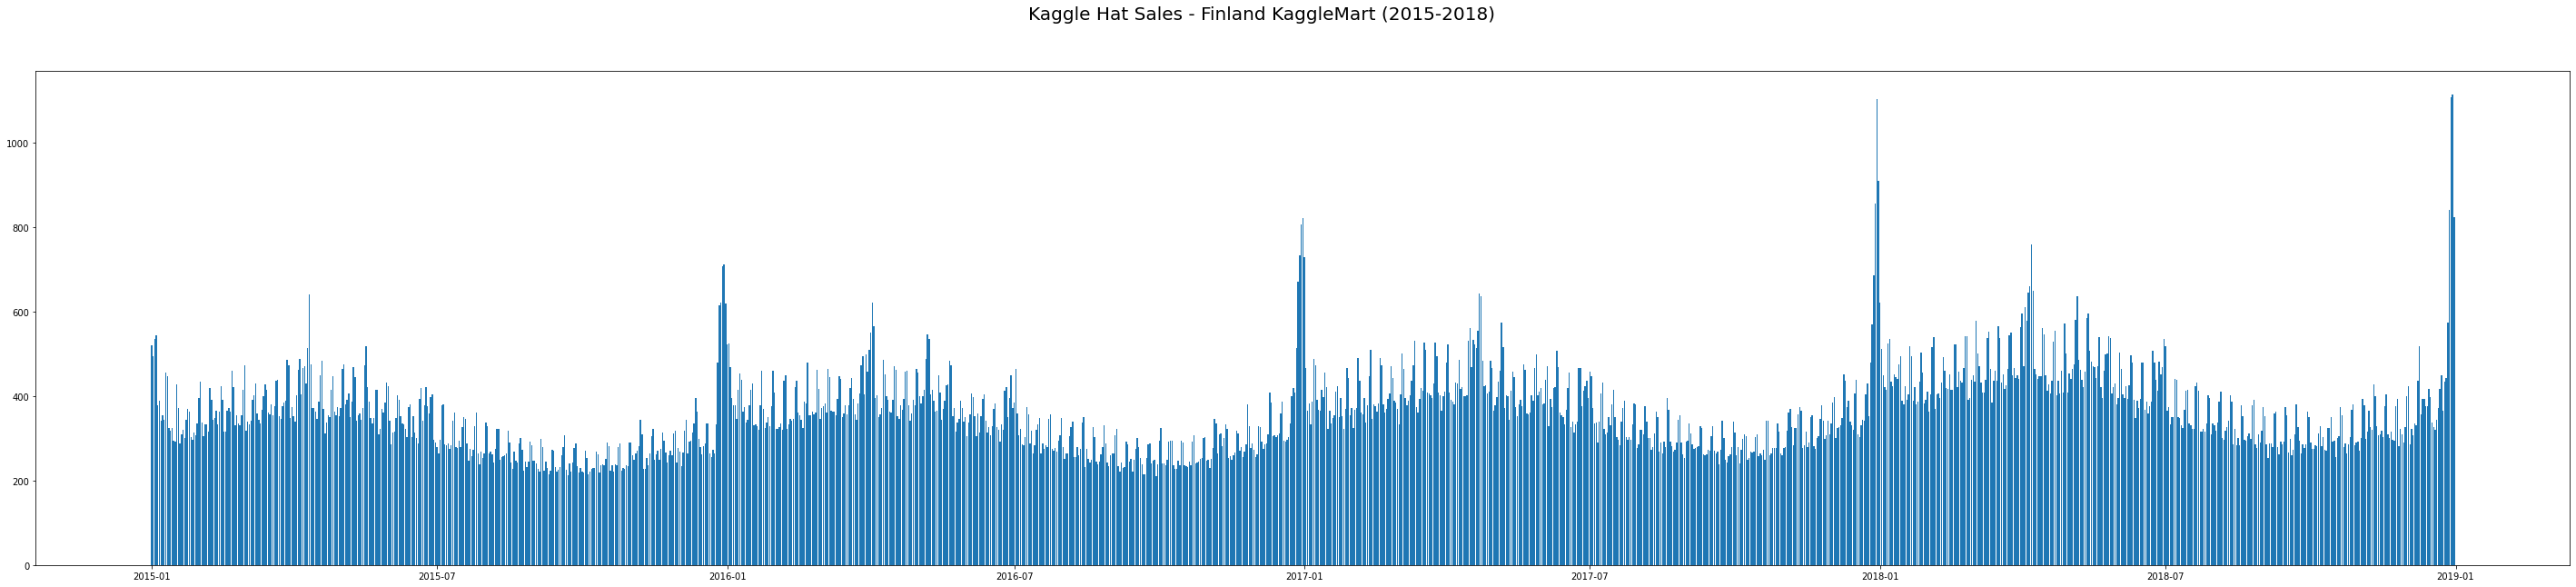

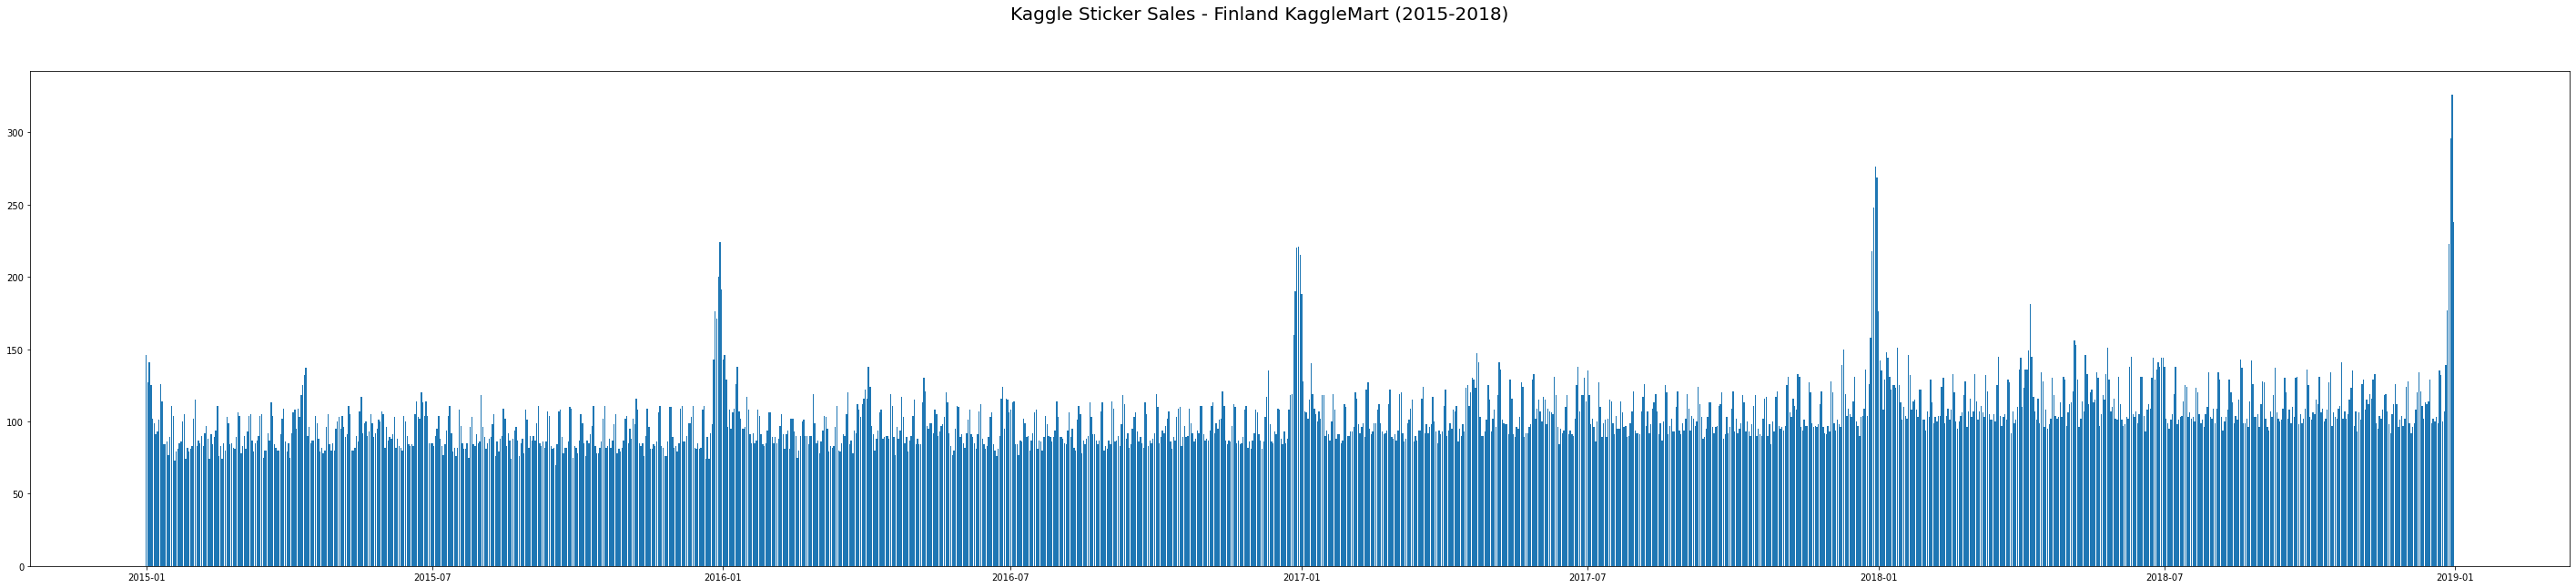

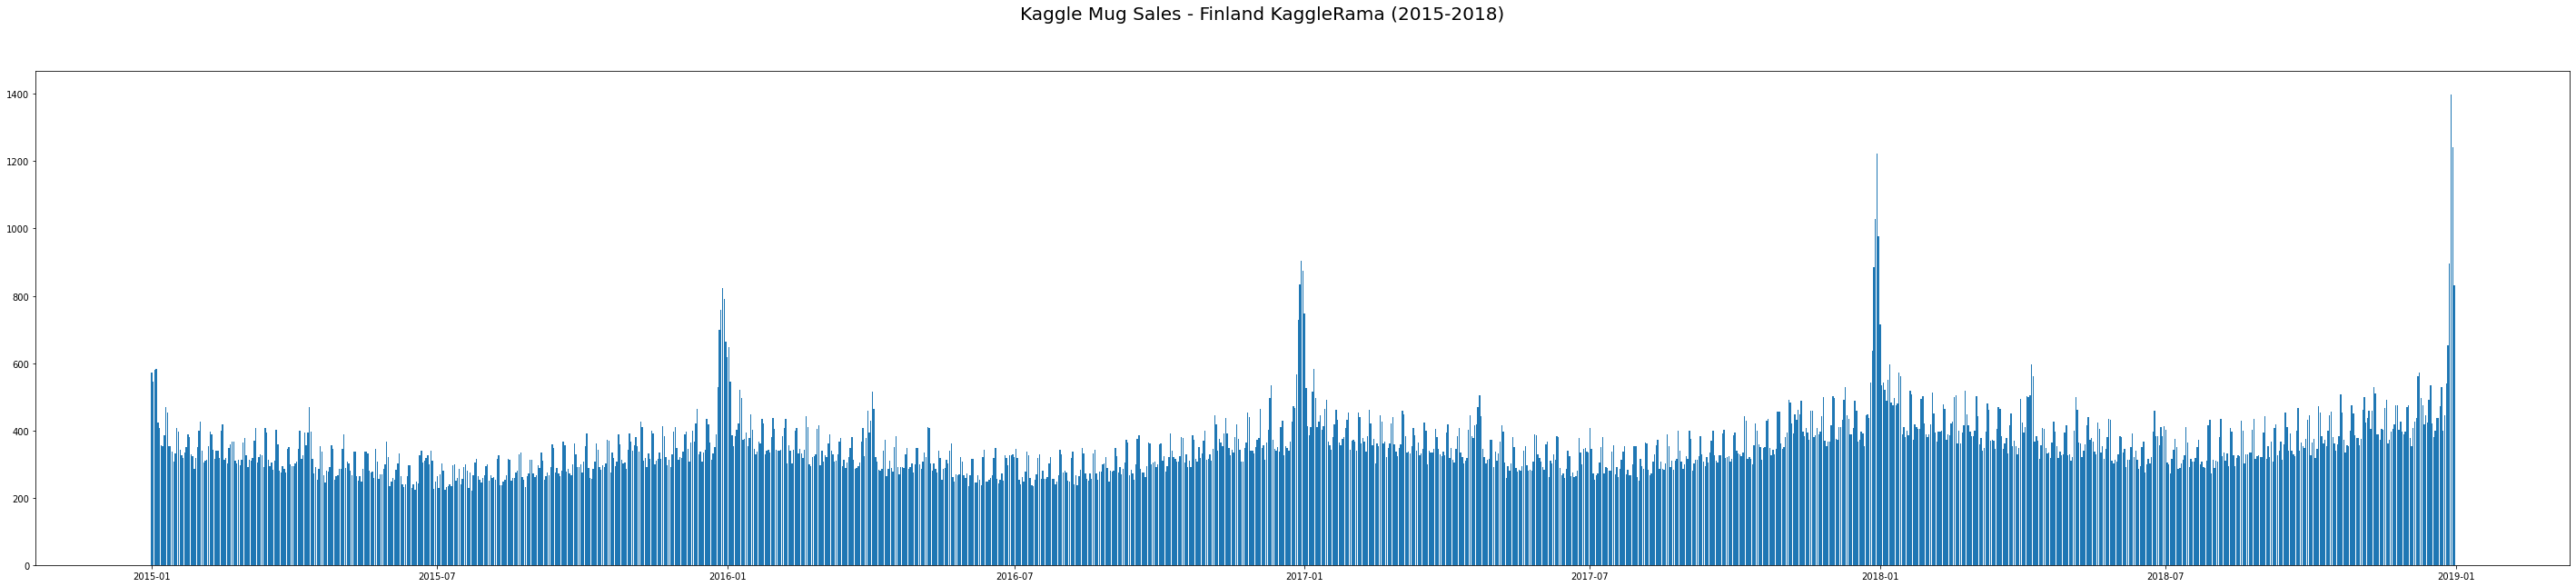

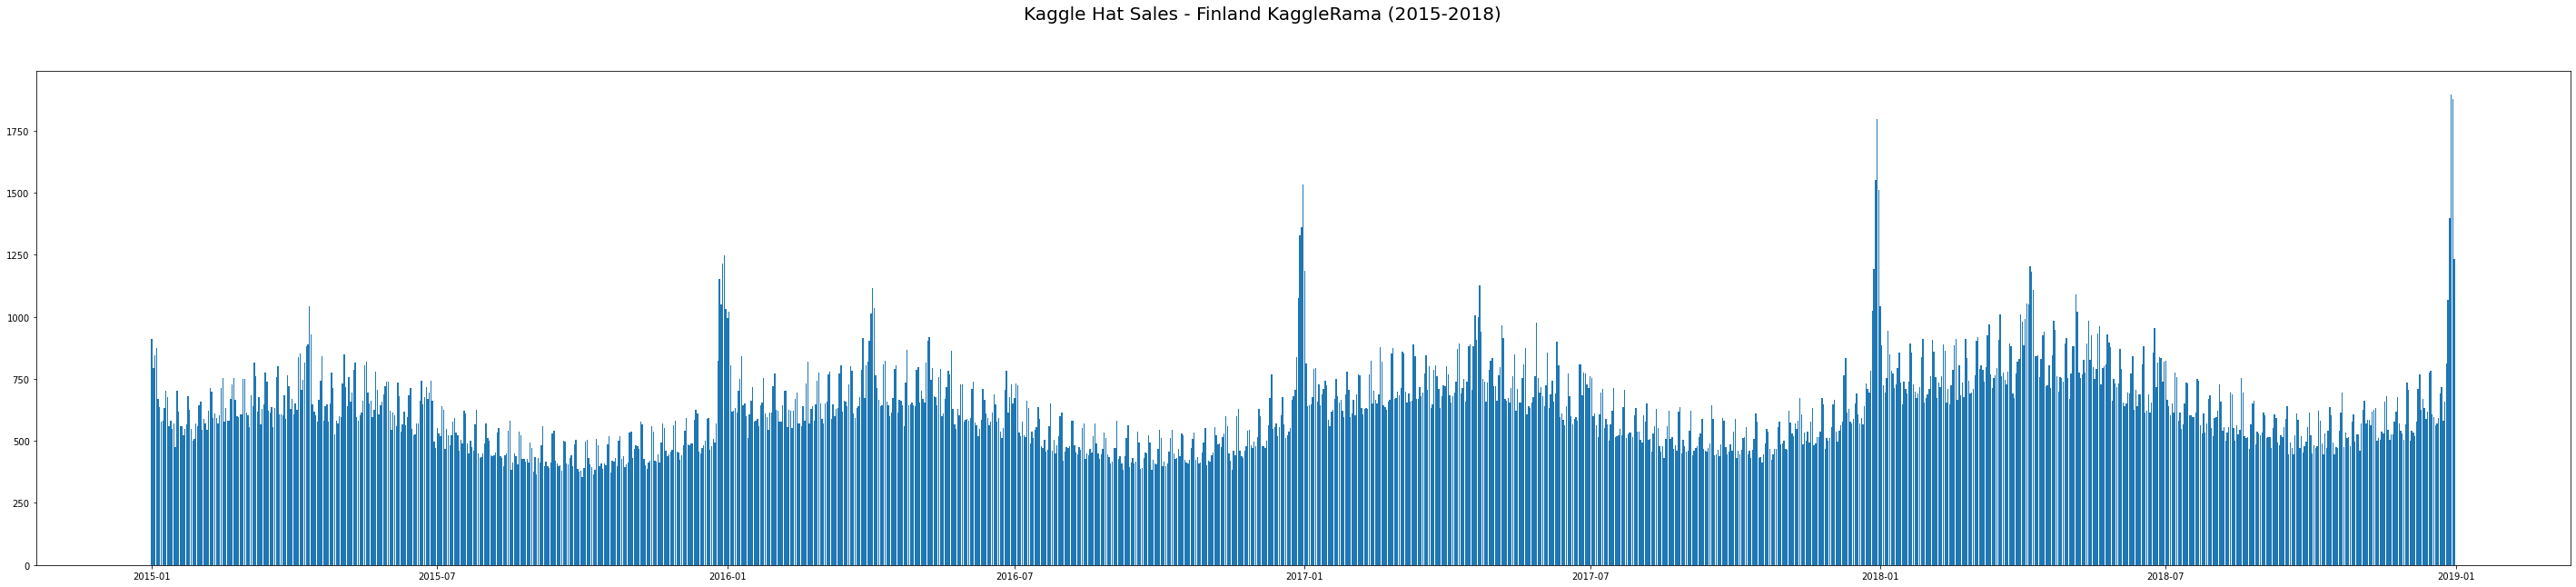

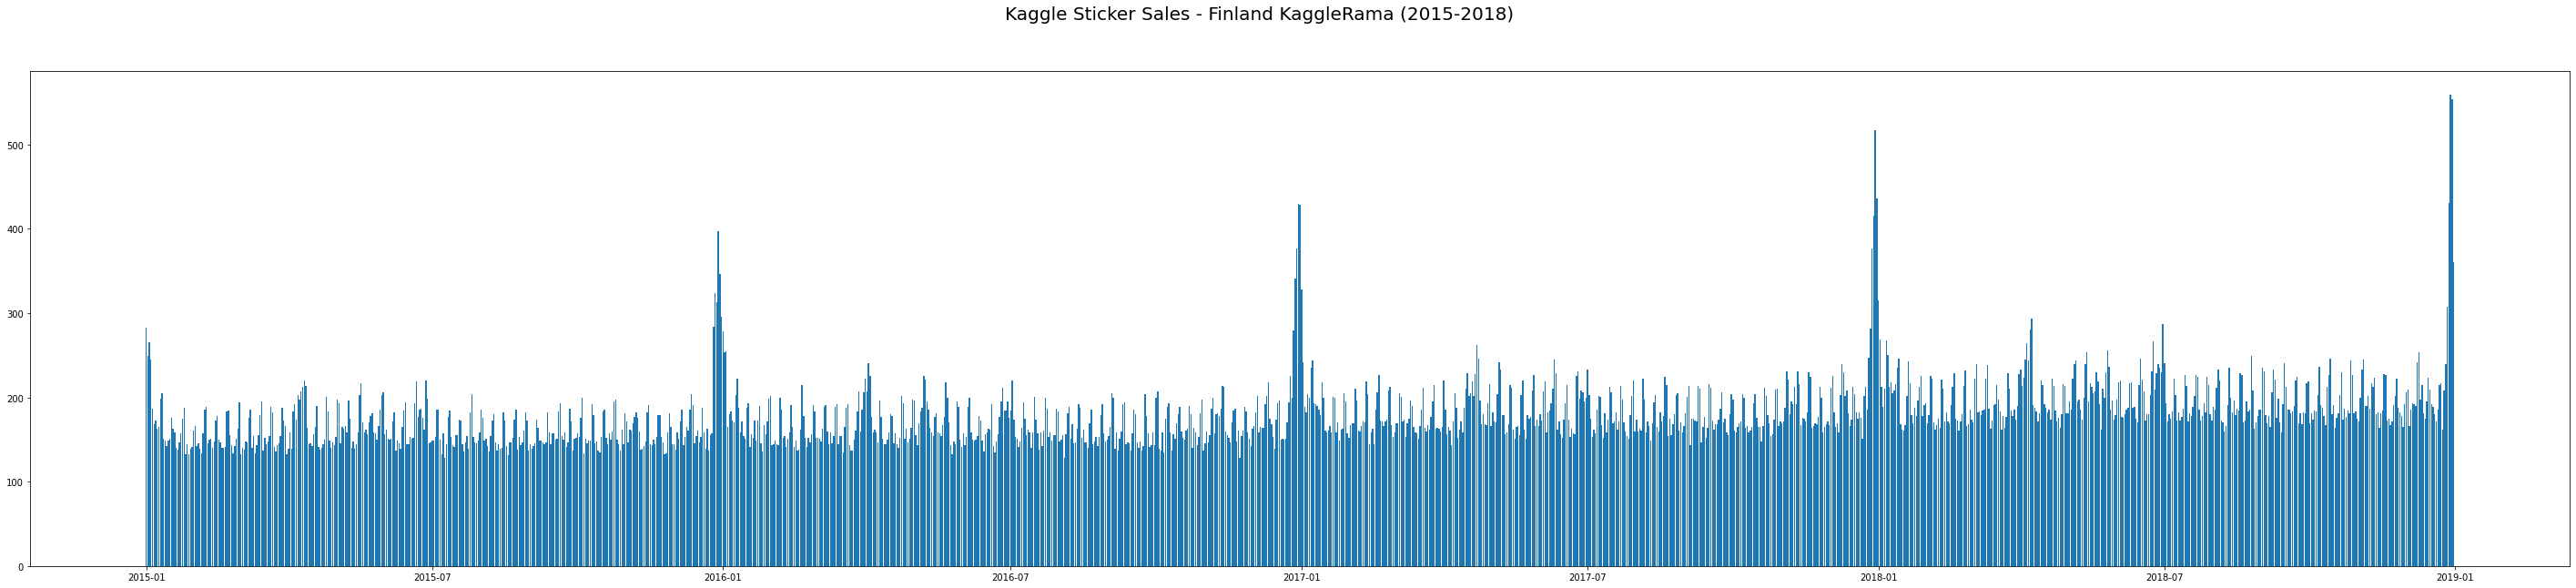

In [22]:
for i in stores:
    for j in products:
        make_sales_graphs('Finland',i,j)

Info from Finland (for Norway and Sweden situatuion is the same)

- There are sales peaks every end of year for the three items. 
- Seasons affect Hat sales signigicantly and mug sales slightly. Sticker sales seems stable over the year.  
- Three item sales seemed to be affected by the day of week.


Text(0, 0.5, 'Number of Sales')

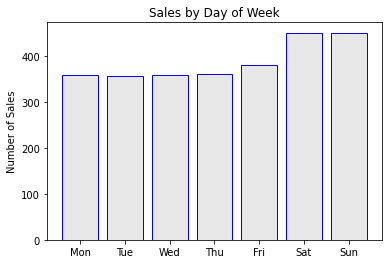

In [25]:
daily_sale = train_df.groupby(by='day_of_week').mean()
plt.bar(np.arange(len(daily_sale)),daily_sale['num_sold'].to_list(),color=(0.1,0.1,0.1,0.1),edgecolor='blue')

plt.xticks(np.arange(len(daily_sale)),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

plt.title('Sales by Day of Week')
plt.ylabel('Number of Sales')


In [26]:
train_df['month'] = pd.DatetimeIndex(train_df.date).month
test_df['month'] = pd.DatetimeIndex(test_df.date).month

Text(0, 0.5, 'Number of Sales')

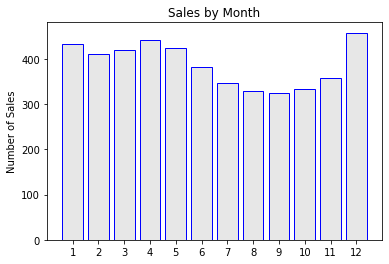

In [27]:
monthly_sale = train_df.groupby(by='month').mean()
plt.bar(np.arange(len(monthly_sale)),monthly_sale['num_sold'].to_list(),color=(0.1,0.1,0.1,0.1),edgecolor='blue')

plt.xticks(np.arange(len(monthly_sale)),range(1,13))

plt.title('Sales by Month')
plt.ylabel('Number of Sales')

**********************************************************************

In [28]:
train_df['step'] = train_df['date']-train_df['date'].shift(1)
zero = np.timedelta64(0, 's')       
train_df['step'][0] = np.timedelta64(0, 's')
train_df['step'] = train_df['step'].apply(lambda x: x>zero).cumsum()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [29]:
test_df['step'] = test_df['date']-test_df['date'].shift(1)     #shift index and find difference
zero = np.timedelta64(0, 's')       
test_df['step'][0] = np.timedelta64(0, 's')          #change first var from naT to zero
test_df['step'] = test_df['step'].apply(lambda x: x>zero).cumsum()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:


train_df['year'] = pd.DatetimeIndex(train_df.date).year
test_df['year'] = pd.DatetimeIndex(test_df.date).year

train_df['day'] = pd.DatetimeIndex(train_df.date).day
test_df['day'] = pd.DatetimeIndex(test_df.date).day

train_df['dayofyear'] = pd.DatetimeIndex(train_df.date).dayofyear
test_df['dayofyear'] = pd.DatetimeIndex(test_df.date).dayofyear

train_df['Quarter'] = pd.DatetimeIndex(train_df.date).quarter
test_df['Quarter'] = pd.DatetimeIndex(test_df.date).quarter

train_df['week'] = pd.DatetimeIndex(train_df.date).weekofyear
test_df['week'] = pd.DatetimeIndex(test_df.date).weekofyear

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


In [31]:
import holidays

# Country List:['Finland' 'Norway' 'Sweden']
holiday_FI = holidays.CountryHoliday('FI', years=[2015, 2016, 2017, 2018, 2019])
holiday_NO = holidays.CountryHoliday('NO', years=[2015, 2016, 2017, 2018, 2019])
holiday_SE = holidays.CountryHoliday('SE', years=[2015, 2016, 2017, 2018, 2019])

holiday_dict = holiday_FI.copy()
holiday_dict.update(holiday_NO)
holiday_dict.update(holiday_SE)

train_df['date'] = pd.to_datetime(train_df['date']) # Convert the date to datetime.
train_df['holiday_name'] = train_df['date'].map(holiday_dict)
train_df['is_holiday'] = np.where(train_df['holiday_name'].notnull(), 1, 0)
train_df['holiday_name'] = train_df['holiday_name'].fillna('Not Holiday')

test_df['date'] = pd.to_datetime(test_df['date']) # Convert the date to datetime.
test_df['holiday_name'] = test_df['date'].map(holiday_dict)
test_df['is_holiday'] = np.where(test_df['holiday_name'].notnull(), 1, 0)
test_df['holiday_name'] = test_df['holiday_name'].fillna('Not Holiday')

In [33]:
train_df['holiday_month'] = [1 if a in[1,4,12] else 0 for a in train_df.month]
test_df['holiday_month'] = [1 if a in[1,4,12] else 0 for a in test_df.month]

In [34]:
train_df['Lag_1'] = train_df['num_sold'].shift(18)

In [35]:
categories = ['country','store','product','holiday_name']
for i in categories:
    encoder = preprocessing.LabelEncoder()
    train_df[i] = encoder.fit_transform(train_df[i])
    test_df[i] =  encoder.transform(test_df[i])

In [36]:
train_df.head(8)

,date,country,store,product,num_sold,GDPperCapita,GrowthRate,day_of_week,weekend,month,step,year,day,dayofyear,Quarter,week,holiday_name,is_holiday,holiday_month,Lag_1
row_id,,,,,,,,,,,,,,,,,,,,
0,2015-01-01,0,0,1,329,-1.171121,-1.324930,3,0,1,0,2015,1,1,1,1,19,1,1,NaN
1,2015-01-01,0,0,0,520,-1.171121,-1.324930,3,0,1,0,2015,1,1,1,1,19,1,1,NaN
2,2015-01-01,0,0,2,146,-1.171121,-1.324930,3,0,1,0,2015,1,1,1,1,19,1,1,NaN
3,2015-01-01,0,1,1,572,-1.171121,-1.324930,3,0,1,0,2015,1,1,1,1,19,1,1,NaN
4,2015-01-01,0,1,0,911,-1.171121,-1.324930,3,0,1,0,2015,1,1,1,1,19,1,1,NaN
5,2015-01-01,0,1,2,283,-1.171121,-1.324930,3,0,1,0,2015,1,1,1,1,19,1,1,NaN
6,2015-01-01,1,0,1,526,1.240299,-2.161896,3,0,1,0,2015,1,1,1,1,19,1,1,NaN
7,2015-01-01,1,0,0,906,1.240299,-2.161896,3,0,1,0,2015,1,1,1,1,19,1,1,NaN


In [37]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [38]:
train_df['step^2'] = train_df['step']**2
test_df['step^2']  = test_df['step']**2

In [39]:
features = train_df[['country','store','product','step','step^2']]
targets = train_df['num_sold'] 

In [40]:
# split data
X_train,X_val,y_train,y_val = train_test_split(features,targets,test_size=0.05,shuffle=False)


In [41]:
model2 = LinearRegression()
model2.fit(X_train, y_train)

LinearRegression()

In [42]:
smape(y_val,model2.predict(X_val))

30.130346723258953

In [43]:
Finland_0_1 = train_df[(train_df['country'] ==0) & (train_df['store']==0) & (train_df['product']==0)]

In [44]:
Finland_0_1.columns

Index(['date', 'country', 'store', 'product', 'num_sold', 'GDPperCapita',
       'GrowthRate', 'day_of_week', 'weekend', 'month', 'step', 'year', 'day',
       'dayofyear', 'Quarter', 'week', 'holiday_name', 'is_holiday',
       'holiday_month', 'Lag_1', 'step^2'],
      dtype='object')

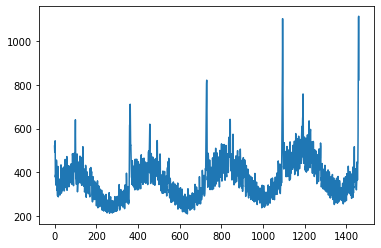

In [45]:
plt.plot(Finland_0_1.step,Finland_0_1.num_sold)


In [46]:
features = Finland_0_1[['day_of_week',
       'weekend', 'step', 'year', 'day', 'dayofyear', 'Quarter', 'week',
       'month', 'holiday_month','step^2' ]]
                       
targets = Finland_0_1['num_sold']

In [47]:
# split data
X_train,X_val,y_train,y_val = train_test_split(features,targets,test_size=0.05,shuffle=False)

In [48]:
model1 = LinearRegression()
model1.fit(X_train, y_train)
predictions = model1.predict(X_val)
smape(y_val,predictions)

12.665363411030036

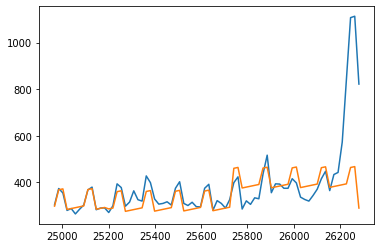

In [49]:
plt.plot(X_val.index,y_val)
plt.plot(X_val.index,predictions)


In [50]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

params = {'lambda': 0.5364370292238032, 'alpha': 7.216972825550576, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.008, 'n_estimators': 1500, 'max_depth': 17, 'min_child_weight': 1}
xgb = xgb.XGBRegressor(n_estimators=1000)
xgb.fit(X_train, y_train,
        eval_set=[(X_train,y_train),(X_val, y_val)],
        early_stopping_rounds=25,
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=2,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

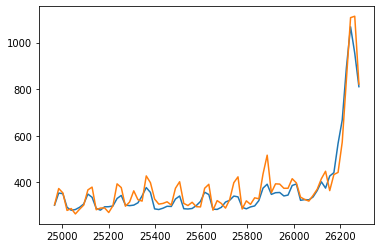

In [51]:
predictions = xgb.predict(X_val)
plt.plot(X_val.index,predictions)
plt.plot(X_val.index,y_val)


In [52]:
smape(y_val,predictions)

7.5537876592171305

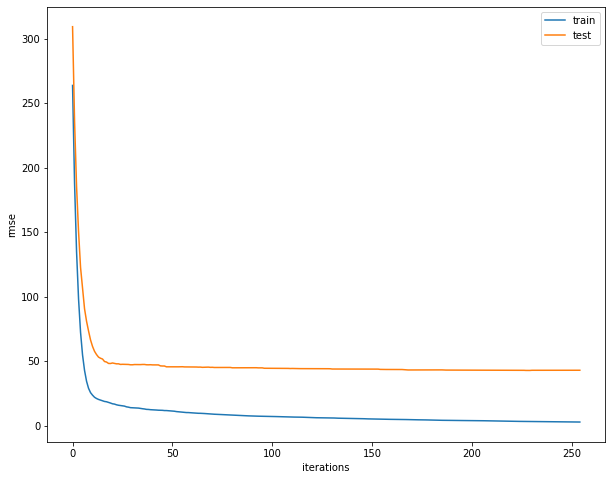

In [53]:
from matplotlib import pyplot
# plot learning curves
results = xgb.evals_result()
plt.figure(figsize=(10, 8))
pyplot.plot(results['validation_0']['rmse'], label='train')
pyplot.plot(results['validation_1']['rmse'], label='test')
# show the legend
pyplot.legend()
plt.xlabel('iterations')
plt.ylabel('rmse')
# show the plot
pyplot.show()

In [54]:
features.columns

Index(['day_of_week', 'weekend', 'step', 'year', 'day', 'dayofyear', 'Quarter',
       'week', 'month', 'holiday_month', 'step^2'],
      dtype='object')

In [55]:
features = train_df[['country','store','product','day','month','year','week','Quarter','dayofyear','day_of_week','step','step^2','is_holiday','holiday_month','holiday_name','GDPperCapita','GrowthRate']]
targets = train_df['num_sold']

In [56]:
# split data
X_train,X_val,y_train,y_val = train_test_split(features,targets,test_size=0.05,shuffle=False)

In [57]:
model1 = LinearRegression()
model1.fit(X_train, y_train)
smape(y_val,model1.predict(X_val))

33.69112998966033

In [58]:
model1.predict(X_val)

array([198.66252899, 200.11227226, 425.29264795, ..., 334.15227636,
       559.33265204, 108.97190067])

In [59]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

xgb = xgb.XGBRegressor(n_estimators=1000)
xgb.fit(X_train, y_train,
        eval_set=[(X_train,y_train),(X_val, y_val)],
        early_stopping_rounds=25,
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=2,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [60]:
predictions = xgb.predict(X_val)
smape(y_val,predictions)


6.341207304969681

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

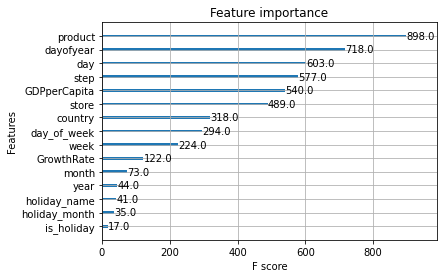

In [61]:
plot_importance(xgb)

In [62]:
results = xgb.evals_result()

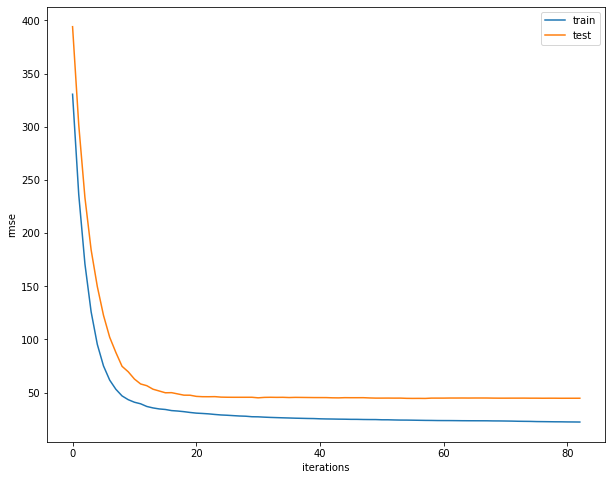

In [63]:
from matplotlib import pyplot
# plot learning curves
plt.figure(figsize=(10, 8))
pyplot.plot(results['validation_0']['rmse'], label='train')
pyplot.plot(results['validation_1']['rmse'], label='test')
# show the legend
pyplot.legend()
plt.xlabel('iterations')
plt.ylabel('rmse')
# show the plot
pyplot.show()

In [64]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor()
cat.fit(X_train,y_train,eval_set=(X_val,y_val),early_stopping_rounds=500,verbose=False)
smape(y_val,cat.predict(X_val))

5.733591260538952

In [65]:
def objective(trial,X,y, name='xgb'):
    params = param = {
        'tree_method':'gpu_hist',  
        'lambda': trial.suggest_loguniform(
            'lambda', 1e-3, 10.0
        ),
        'alpha': trial.suggest_loguniform(
            'alpha', 1e-3, 10.0
        ),
        'eta': trial.suggest_float('eta', 1e-5, 0.1),
        'colsample_bytree': trial.suggest_categorical(
            'colsample_bytree', [0.5,0.6,0.7,0.8,0.9,1.0]
        ),
        'subsample': trial.suggest_categorical( 
            'subsample', [0.6,0.7,0.8,1.0]
        ),
        'learning_rate': trial.suggest_categorical(
            'learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]
        ),
        'n_estimators': trial.suggest_categorical(
            "n_estimators", [150, 200, 300,1000, 1500,2000, 3000]
        ),
        'max_depth': trial.suggest_categorical(
            'max_depth', [4,5,7,9,11,13,15,17]
        ),
        'random_state': 42,
        'min_child_weight': trial.suggest_int(
            'min_child_weight', 1, 300
        ),
        'random_state':10
    }

    model =  XGBRegressor(**params)
    model.fit(X_train,y_train,eval_set=[(X_val,y_val)],early_stopping_rounds=50,verbose=False)


    train_score = np.round(np.sqrt(mean_squared_error(y_train, model.predict(X_train))), 5)
    test_score = np.round(np.sqrt(mean_squared_error(y_val, model.predict(X_val))), 5)
                  
    print(f'TRAIN RMSE : {train_score} || TEST RMSE : {test_score}')
                  
    return test_score

In [68]:
params ={'lambda': 0.0012338191278124635, 'alpha': 3.284395992431614, 'eta': 0.09886834650237164, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.018, 'n_estimators': 2000, 'max_depth': 5, 'min_child_weight': 3}

In [69]:
xgb = XGBRegressor(**params)
xgb.fit(X_train, y_train,
        eval_set=[(X_train,y_train),(X_val, y_val)],
        early_stopping_rounds=60,
       verbose=False)

XGBRegressor(alpha=3.284395992431614, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
             enable_categorical=False, eta=0.09886834650237164, gamma=0,
             gpu_id=-1, importance_type=None, interaction_constraints='',
             lambda=0.0012338191278124635, learning_rate=0.018,
             max_delta_step=0, max_depth=5, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=2000, n_jobs=2,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=3.28439593, reg_lambda=0.00123381917, scale_pos_weight=1,
             subsample=0.6, tree_method='exact', validate_parameters=1, ...)

In [70]:
predictions = xgb.predict(X_val)
smape(y_val,predictions)



5.104103784654629

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

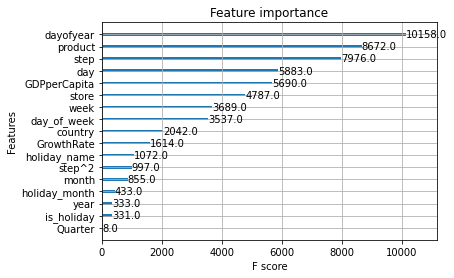

In [71]:
plot_importance(xgb)

In [72]:
results = xgb.evals_result()

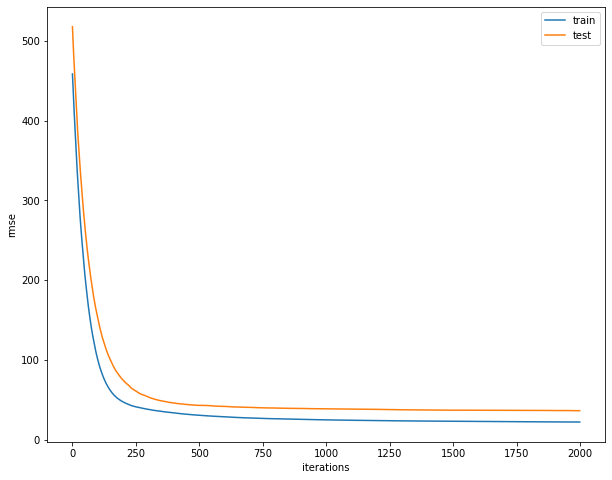

In [73]:
from matplotlib import pyplot
# plot learning curves
results = xgb.evals_result()
plt.figure(figsize=(10, 8))
pyplot.plot(results['validation_0']['rmse'], label='train')
pyplot.plot(results['validation_1']['rmse'], label='test')
# show the legend
pyplot.legend()
plt.xlabel('iterations')
plt.ylabel('rmse')
# show the plot
pyplot.show()

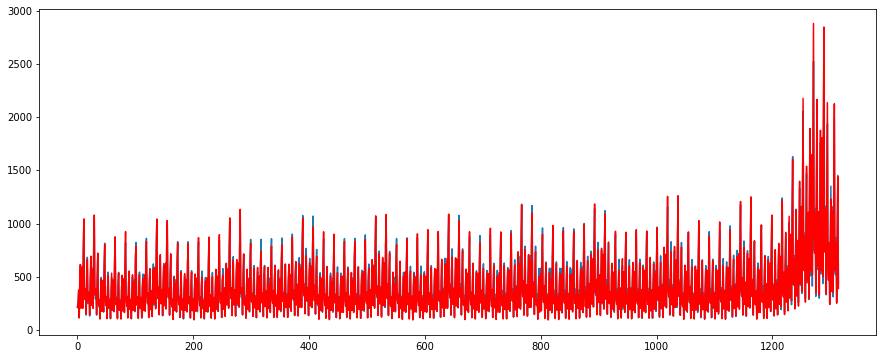

In [74]:
y = predictions
x = range(len(predictions))
plt.figure(figsize=(15,6))
plt.plot(x,y)
plt.plot(x,y_val,'red')

In [75]:
predictions1 = xgb.predict(test_df[['country','store','product','day','month','year','week','Quarter','dayofyear','day_of_week','step','step^2','is_holiday','holiday_month','holiday_name','GDPperCapita','GrowthRate']])
predictions2 = cat.predict(test_df[['country','store','product','day','month','year','week','Quarter','dayofyear','day_of_week','step','step^2','is_holiday','holiday_month','holiday_name','GDPperCapita','GrowthRate']])                                   

In [76]:
predictions = (predictions1+predictions2)/2

In [77]:
output = pd.read_csv('sample_submission.csv')
output['num_sold']= predictions

